2025-08-27 18:10:46.571 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 18:10:46.572 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 18:10:46.647 
  command:

    streamlit run /home/vscode/.local/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-08-27 18:10:46.648 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 18:10:46.648 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 18:10:46.649 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-27 18:10:46.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored whe

DeltaGenerator()

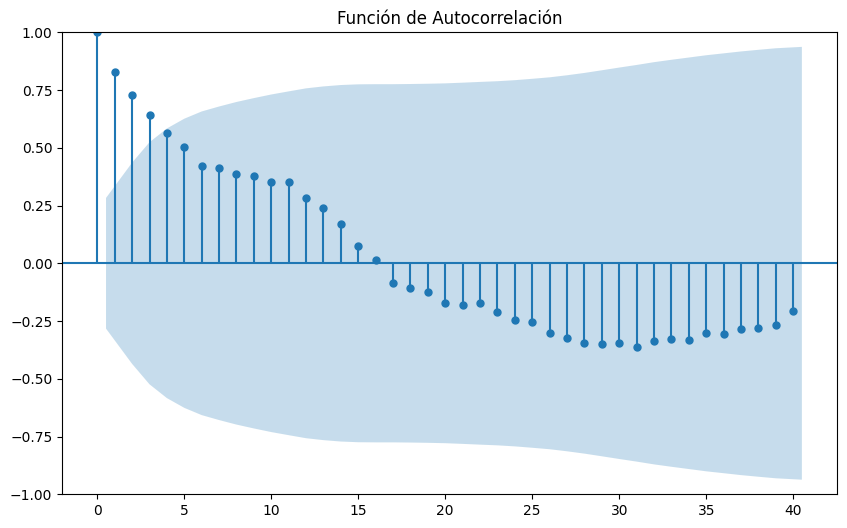

In [ ]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Configurar warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)

# Configuración de la página
st.set_page_config(
    page_title="Análisis de Series Temporales",
    page_icon="📈",
    layout="wide"
)

# Título principal
st.title(" Análisis de Series Temporales - Ventas")
st.markdown("---")

# Sidebar para controles
st.sidebar.header(" Configuración")

# Función para cargar datos de ejemplo
@st.cache_data
def create_sample_data():
    """Crear datos de ejemplo si no se cargan datos reales"""
    dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='M')
    np.random.seed(42)
    trend = np.linspace(100, 200, len(dates))
    seasonal = 20 * np.sin(2 * np.pi * np.arange(len(dates)) / 12)
    noise = np.random.normal(0, 10, len(dates))
    sales = trend + seasonal + noise
    
    df = pd.DataFrame({
        'date': dates,
        'sales': sales
    })
    return df

# Función para procesar datos
@st.cache_data
def process_data(df):
    """Procesar los datos de la serie temporal"""
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")
    ts = df["sales"]
    return ts

# Función para test de estacionariedad
def test_stationarity(timeseries):
    """Realizar test de Dickey-Fuller"""
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
    return dfoutput

# Carga de datos
st.sidebar.subheader(" Carga de Datos")
uploaded_file = st.sidebar.file_uploader("Sube tu archivo CSV", type=['csv'])

if uploaded_file is not None:
    try:
        total_data = pd.read_csv(uploaded_file)
        st.sidebar.success(" Archivo cargado correctamente")
    except Exception as e:
        st.sidebar.error(f"❌ Error al cargar archivo: {e}")
        total_data = create_sample_data()
        st.sidebar.info("📊 Usando datos de ejemplo")
else:
    total_data = create_sample_data()
    st.sidebar.info("📊 Usando datos de ejemplo")

# Procesar datos
ts = process_data(total_data)

# Información básica de la serie
st.subheader("Información de la Serie Temporal")
col1, col2, col3, col4 = st.columns(4)

with col1:
    st.metric("Observaciones", len(ts))
with col2:
    st.metric("Fecha inicio", ts.index.min().strftime('%Y-%m-%d'))
with col3:
    st.metric("Fecha fin", ts.index.max().strftime('%Y-%m-%d'))
with col4:
    st.metric("Frecuencia", ts.index.inferred_freq or "No detectada")

# Mostrar primeras observaciones
st.subheader("🔍 Primeras Observaciones")
st.dataframe(ts.head(10))

# Visualización de la serie temporal
st.subheader("📈 Visualización de la Serie Temporal")

fig_ts = go.Figure()
fig_ts.add_trace(go.Scatter(
    x=ts.index,
    y=ts.values,
    mode='lines',
    name='Ventas',
    line=dict(color='blue', width=2)
))
fig_ts.update_layout(
    title='Serie Temporal de Ventas',
    xaxis_title='Fecha',
    yaxis_title='Ventas',
    height=500
)
st.plotly_chart(fig_ts, use_container_width=True)

# Descomposición estacional
st.subheader(" Descomposición Estacional")

period = st.sidebar.slider("Período para descomposición", min_value=4, max_value=24, value=12)

try:
    decomposition = seasonal_decompose(ts, period=period)
    
    # Crear subplots para la descomposición
    fig_decomp = make_subplots(
        rows=4, cols=1,
        subplot_titles=('Serie Original', 'Tendencia', 'Estacionalidad', 'Residuos'),
        vertical_spacing=0.08
    )
    
    # Serie original
    fig_decomp.add_trace(go.Scatter(x=ts.index, y=ts.values, name='Original', line=dict(color='blue')), row=1, col=1)
    
    # Tendencia
    fig_decomp.add_trace(go.Scatter(x=ts.index, y=decomposition.trend, name='Tendencia', line=dict(color='red')), row=2, col=1)
    
    # Estacionalidad
    fig_decomp.add_trace(go.Scatter(x=ts.index, y=decomposition.seasonal, name='Estacional', line=dict(color='green')), row=3, col=1)
    
    # Residuos
    fig_decomp.add_trace(go.Scatter(x=ts.index, y=decomposition.resid, name='Residuos', line=dict(color='orange')), row=4, col=1)
    
    fig_decomp.update_layout(height=800, showlegend=False, title_text="Descomposición de la Serie Temporal")
    st.plotly_chart(fig_decomp, use_container_width=True)
    
    # Análisis de componentes
    col1, col2 = st.columns(2)
    
    with col1:
        st.subheader(" Análisis de Tendencia")
        fig_trend = go.Figure()
        fig_trend.add_trace(go.Scatter(x=ts.index, y=ts.values, name='Serie Original', line=dict(color='blue', width=1)))
        fig_trend.add_trace(go.Scatter(x=ts.index, y=decomposition.trend, name='Tendencia', line=dict(color='red', width=3)))
        fig_trend.update_layout(title='Serie Original vs Tendencia', height=400)
        st.plotly_chart(fig_trend, use_container_width=True)
    
    with col2:
        st.subheader("🌊 Análisis de Estacionalidad")
        fig_seasonal = go.Figure()
        fig_seasonal.add_trace(go.Scatter(x=ts.index, y=ts.values, name='Serie Original', line=dict(color='blue', width=1)))
        fig_seasonal.add_trace(go.Scatter(x=ts.index, y=decomposition.seasonal, name='Estacionalidad', line=dict(color='green', width=2)))
        fig_seasonal.update_layout(title='Serie Original vs Estacionalidad', height=400)
        st.plotly_chart(fig_seasonal, use_container_width=True)

except Exception as e:
    st.error(f"Error en la descomposición: {e}")

# Test de estacionariedad
st.subheader("🧪 Test de Estacionariedad (Dickey-Fuller)")

col1, col2 = st.columns(2)

with col1:
    st.write("**Serie Original:**")
    df_test_original = test_stationarity(ts.dropna())
    st.dataframe(df_test_original)
    
    p_value_original = df_test_original['p-value']
    if p_value_original < 0.05:
        st.success("La serie es estacionaria (p < 0.05)")
    else:
        st.warning(" La serie NO es estacionaria (p >= 0.05)")

with col2:
    st.write("**Serie Diferenciada:**")
    ts_diff = ts.diff().dropna()
    df_test_diff = test_stationarity(ts_diff)
    st.dataframe(df_test_diff)
    
    p_value_diff = df_test_diff['p-value']
    if p_value_diff < 0.05:
        st.success(" La serie diferenciada es estacionaria (p < 0.05)")
    else:
        st.warning(" La serie diferenciada NO es estacionaria (p >= 0.05)")

# Visualización de serie diferenciada
st.subheader("📉 Serie Diferenciada")
fig_diff = go.Figure()
fig_diff.add_trace(go.Scatter(
    x=ts_diff.index,
    y=ts_diff.values,
    mode='lines',
    name='Serie Diferenciada',
    line=dict(color='purple', width=2)
))
fig_diff.update_layout(
    title='Serie Temporal Diferenciada',
    xaxis_title='Fecha',
    yaxis_title='Diferencia en Ventas',
    height=400
)
st.plotly_chart(fig_diff, use_container_width=True)

# Análisis de autocorrelación
st.subheader("🔗 Análisis de Autocorrelación")

try:
    # Crear gráfico de autocorrelación con matplotlib y convertir a streamlit
    fig_acf, ax = plt.subplots(figsize=(10, 6))
    plot_acf(ts.dropna(), ax=ax, lags=40)
    ax.set_title('Función de Autocorrelación')
    st.pyplot(fig_acf)
except Exception as e:
    st.error(f"Error en el análisis de autocorrelación: {e}")

# Predicción con ARIMA (simulada)
st.subheader(" Predicción ARIMA")

st.info(" **Nota:** Para usar ARIMA real, instala: `pip install pmdarima`")

# Simulación de predicción
forecast_periods = st.sidebar.slider("Períodos a predecir", min_value=1, max_value=24, value=10)

# Predicción simple (tendencia lineal como ejemplo)
try:
    # Calcular tendencia simple
    x = np.arange(len(ts))
    y = ts.values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    # Generar predicciones futuras
    future_x = np.arange(len(ts), len(ts) + forecast_periods)
    future_dates = pd.date_range(start=ts.index[-1], periods=forecast_periods + 1, freq=ts.index.inferred_freq or 'M')[1:]
    forecast_values = p(future_x)
    
    # Visualizar predicción
    fig_forecast = go.Figure()
    
    # Serie histórica
    fig_forecast.add_trace(go.Scatter(
        x=ts.index,
        y=ts.values,
        mode='lines',
        name='Datos Históricos',
        line=dict(color='blue', width=2)
    ))
    
    # Predicción
    fig_forecast.add_trace(go.Scatter(
        x=future_dates,
        y=forecast_values,
        mode='lines+markers',
        name='Predicción',
        line=dict(color='red', width=2, dash='dash')
    ))
    
    fig_forecast.update_layout(
        title='Predicción de Ventas (Tendencia Lineal)',
        xaxis_title='Fecha',
        yaxis_title='Ventas',
        height=500
    )
    st.plotly_chart(fig_forecast, use_container_width=True)
    
    # Mostrar valores predichos
    st.subheader(" Valores Predichos")
    forecast_df = pd.DataFrame({
        'Fecha': future_dates,
        'Predicción': forecast_values
    })
    st.dataframe(forecast_df)
    
except Exception as e:
    st.error(f"Error en la predicción: {e}")

# Estadísticas descriptivas
st.subheader("📊 Estadísticas Descriptivas")
col1, col2 = st.columns(2)

with col1:
    st.write("**Serie Original:**")
    st.dataframe(ts.describe())

with col2:
    st.write("**Serie Diferenciada:**")
    st.dataframe(ts_diff.describe())

# Footer
st.markdown("---")
st.markdown("*Desarrollado con Streamlit - Análisis de Series Temporales*")
st.markdown(" **Tip:** Para análisis ARIMA completo, instala `pmdarima` y descomenta las secciones correspondientes.")